In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from scipy.cluster.hierarchy import dendrogram, linkage

Dataset loaded. Shape: (1000, 4)
Columns: ['Age', 'Annual_Income', 'Spending_Score', 'Online_Activity']
   Age  Annual_Income  Spending_Score  Online_Activity
0   56             32              37               10
1   46             59              96                5
2   32             21              56               36
3   60            103              59                6
4   25             84               3               26
Numeric features: ['Age', 'Annual_Income', 'Spending_Score', 'Online_Activity']
Categorical features: []
Preprocessed feature matrix shape: (1000, 4)


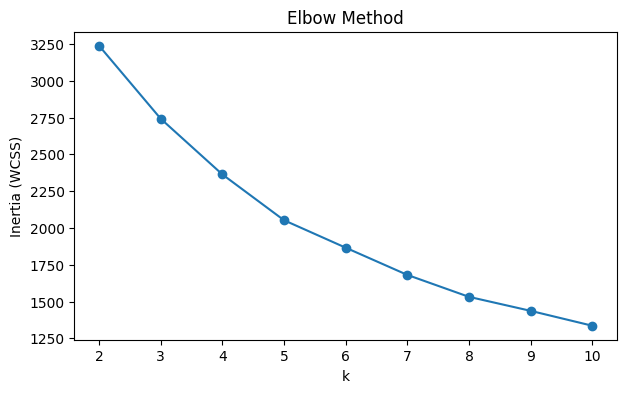

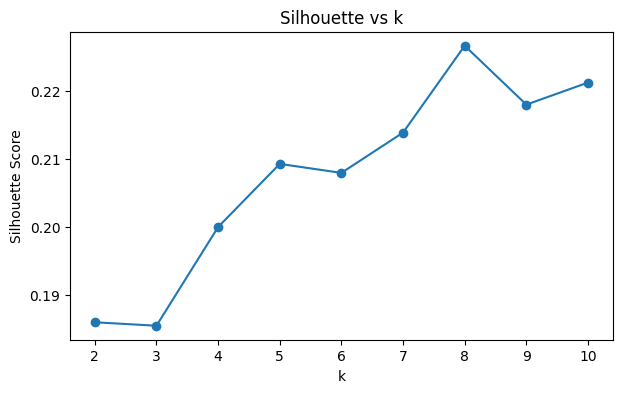


== KMeans (k=5) ==
n_clusters: 5
silhouette: 0.20925964508730605
calinski_harabasz: 236.0052434039963
davies_bouldin: 1.3235856266064563
inertia: 2052.582233072956


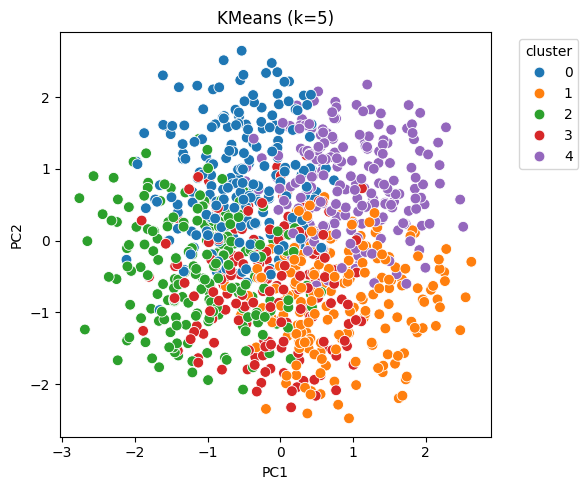


== MiniBatchKMeans (k=5) ==
n_clusters: 5
silhouette: 0.20347432587653042
calinski_harabasz: 225.42174973219798
davies_bouldin: 1.3226002659786924


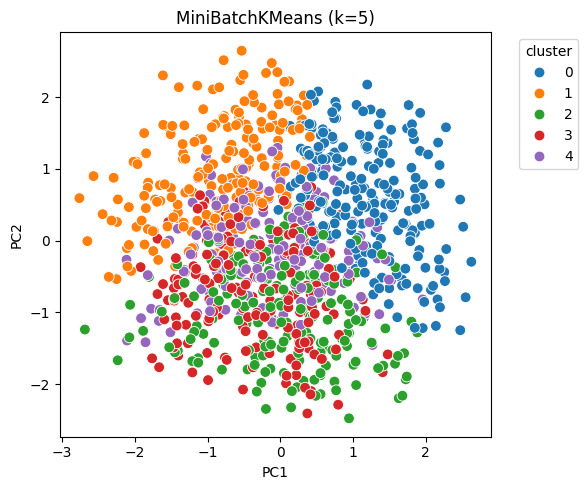


== Hierarchical (k=5) ==
n_clusters: 5
silhouette: 0.14945081815923464
calinski_harabasz: 183.46020387807562
davies_bouldin: 1.4885505765777278


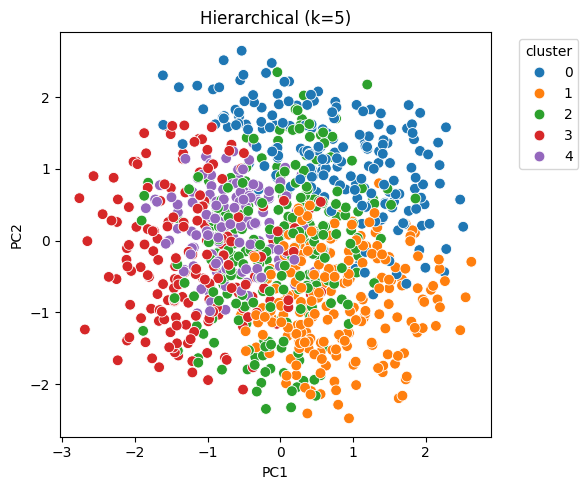

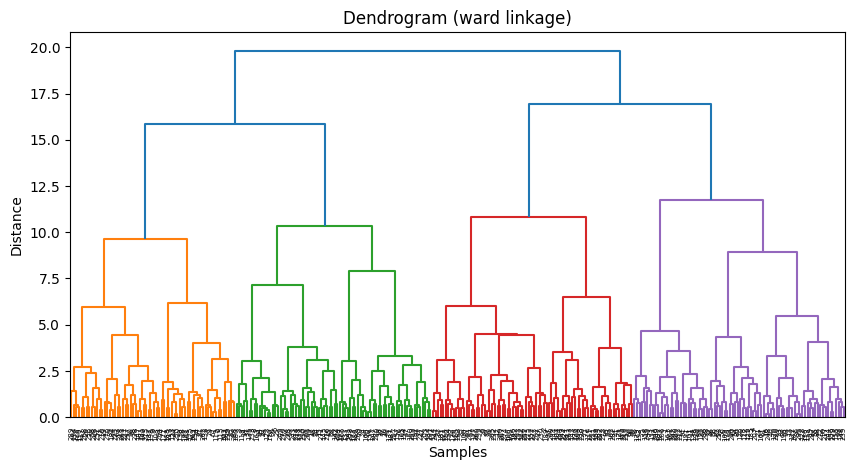


Cluster profile (KMeans):
                 Age               Annual_Income               Spending_Score  \
               count   mean    std         count   mean    std          count   
kmeans_cluster                                                                  
0                209  43.23  12.75           209  45.05  16.53            209   
1                198  27.09   6.81           198  59.55  23.99            198   
2                203  42.32  12.04           203  99.96  13.38            203   
3                187  37.98  11.78           187  89.85  20.75            187   
4                203  53.67   7.02           203  54.29  22.10            203   

                             Online_Activity                
                 mean    std           count   mean    std  
kmeans_cluster                                              
0               29.75  19.86             209  10.78   6.81  
1               52.94  26.39             198  30.10   6.80  
2               20.

In [7]:
DATA_PATH = "/content/Mall_customer.csv"   # change if needed

df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

raw_df = df.copy()

# Build preprocessing pipeline
transformers = []
if numeric_features:
    transformers.append(('num', StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(('cat', OneHotEncoder(sparse=False, drop='first'), categorical_features))

preprocessor = ColumnTransformer(transformers)

X = preprocessor.fit_transform(df)
print("Preprocessed feature matrix shape:", X.shape)


#  Utility functions

def evaluate_clusters(X, labels, model_name="Model", compute_inertia=None):
    n_clusters = len(np.unique(labels))
    results = {}
    if n_clusters <= 1 or len(X) <= 1:
        return None
    results['n_clusters'] = n_clusters
    results['silhouette'] = silhouette_score(X, labels)
    results['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    results['davies_bouldin'] = davies_bouldin_score(X, labels)
    if compute_inertia is not None:
        results['inertia'] = compute_inertia
    print(f"\n== {model_name} (k={n_clusters}) ==")
    for k, v in results.items():
        print(f"{k}: {v}")
    return results

def plot_elbow(X, k_range=range(2,11), random_state=42):
    inertias = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.figure(figsize=(7,4))
    plt.plot(list(k_range), inertias, '-o')
    plt.xlabel("k")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow Method")
    plt.show()

def plot_silhouette_scores(X, k_range=range(2,11), random_state=42):
    scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        scores.append(silhouette_score(X, labels))
    plt.figure(figsize=(7,4))
    plt.plot(list(k_range), scores, '-o')
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette vs k")
    plt.show()

def plot_pca_clusters(X, labels, title="Cluster PCA projection"):
    pca = PCA(n_components=2, random_state=0)
    Xp = pca.fit_transform(X)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=labels, palette='tab10', s=60, legend='full')
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_dendrogram(X, method='ward', metric='euclidean', truncate_mode=None, p=30):
    Z = linkage(X, method=method, metric=metric)
    plt.figure(figsize=(10, 5))
    dendrogram(Z, truncate_mode=truncate_mode, p=p)
    plt.title(f"Dendrogram ({method} linkage)")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()
    return Z

#  Explore k

plot_elbow(X, k_range=range(2,11))
plot_silhouette_scores(X, k_range=range(2,11))

# Choose a k (example: 5, adjust based on plots)
K = 5
random_state = 42


# KMeans
kmeans = KMeans(n_clusters=K, n_init=20, random_state=random_state)
k_labels = kmeans.fit_predict(X)
k_results = evaluate_clusters(X, k_labels, model_name="KMeans", compute_inertia=kmeans.inertia_)
plot_pca_clusters(X, k_labels, f"KMeans (k={K})")

# Mini-Batch KMeans
mbk = MiniBatchKMeans(n_clusters=K, batch_size=128, random_state=random_state, n_init=10)
mb_labels = mbk.fit_predict(X)
mb_results = evaluate_clusters(X, mb_labels, model_name="MiniBatchKMeans")
plot_pca_clusters(X, mb_labels, f"MiniBatchKMeans (k={K})")

# Hierarchical
hier = AgglomerativeClustering(n_clusters=K, linkage='ward')
h_labels = hier.fit_predict(X)
h_results = evaluate_clusters(X, h_labels, model_name="Hierarchical")
plot_pca_clusters(X, h_labels, f"Hierarchical (k={K})")

# Dendrogram (sample if too big)
sample_for_dendro = X if X.shape[0] <= 300 else X[np.random.choice(X.shape[0], 300, replace=False)]
plot_dendrogram(sample_for_dendro, method='ward')

#  Attach results to dataframe

df_out = raw_df.copy()
df_out['kmeans_cluster'] = k_labels
df_out['minibatch_cluster'] = mb_labels
df_out['hier_cluster'] = h_labels

print("\nCluster profile (KMeans):")
print(df_out.groupby('kmeans_cluster')[numeric_features].agg(['count','mean','std']).round(2))

df_out.to_csv("segmented_customers.csv", index=False)
print("\nSaved results to segmented_customers.csv")

import json
summary = {
    "kmeans": k_results,
    "minibatch": mb_results,
    "hierarchical": h_results
}
print("\nSummary:")
print(json.dumps(summary, indent=2))